In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from imblearn.ensemble import RUSBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from time import time
import random
import seaborn as sns
from statistics import mode
import random

In [2]:
data_source = 'tcr' # choose rwt or tcr
subject_id_start = 1
subject_id_end = 17 # tcr's max 17; rwt's max 14
subject_id_search = 1
ignore_session_threashold = 0.50
data_status = 'old_'
tcr_subject = [7, 112, 113, 121, 75, 107, 79, 82, 118, 76, 115, 117, 119, 120, 105, 78, 124]
rwt_subject = [7, 112, 113, 114, 75, 107, 79, 82, 118, 76, 115, 117, 119, 120]
new_tcr_trial = [123, 124]
subject = None
if data_status == "old_":
    if data_source == 'tcr':
        subject = tcr_subject
    else:
        subject = rwt_subject
else:
    subject = new_tcr_trial
first_chopped_off = 600 * 0.3
last_chopped_off = 600 * 0

best_classifier_predicted_y = []
second_classifier_predicted_y = []

LDA = {}
GradientBoost = {}
NearestNeighbor = {}
AdaBoost = {}
RandomForest = {}
LinearSVM = {}
RBFSVM = {}
DecisionTree = {}
RUSBoost = {}
sLDA = {}

data_left_for_subjects = {} # records the percentage of data being used for each subject

time_continuity_subject = {} # records the time of time_continuity_algorithm for each subject

subject_accuracy_best_classifier_dict = {} # records the accuracy of the best classifier for each subject

subject_accuracy_top_2_classifier_dict = {} # records the accuracy of the second best classifier for each subject

subject_best_classifier_name = {} # records the name of the best classifier for each subject

subject_accuracy_tmv_dict = {} # records the accuracy of time_majority_algorithm for each subject

subject_preprocess_record = {} # records the number of sessions and folds left for each subjects

subject_prediction = {}

subject_unknown_percentage = {}

time_classifier = {} # records the time it takes for each classifier to execute the 7-fold cross-validation
# define models to train
names = [  
#         'GradientBoostingRegressor',
        'LDA',
        'Nearest Neighbors',
#         'AdaBoostClassifier',
        'RandomForest',
#         "Linear SVM",
        "RBF SVM",
#         "Decision Tree",
#         'RUSBoost',
        'Shrinkage LDA',
        ]

# build classifiers
classifiers = [
#             GradientBoostingRegressor(random_state=1),
            LinearDiscriminantAnalysis(),
            KNeighborsClassifier(n_neighbors=5),
#             AdaBoostClassifier(n_estimators=400, learning_rate = 0.6),
            RandomForestClassifier(n_estimators=300, max_features = "sqrt", oob_score = True),
#             SVC(kernel="linear", C=0.025),
            SVC(gamma=2, C=1),
#             DecisionTreeClassifier(),
#             RUSBoostClassifier(n_estimators = 200, random_state=1),
            LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'),
              ]

dicts_records = [
#                  GradientBoost, 
                 LDA,
                 NearestNeighbor,
#                  AdaBoost, 
                 RandomForest, 
#                  LinearSVM,
                 RBFSVM,
#                  DecisionTree,
#                  RUSBoost, 
                 sLDA
                ]


def check_removed_index(name, removed_dict, index_to_be_removed, lowerBound, upperBound):
    if name not in removed_dict:
        removed_dict[name] = 0
    lst = [i for i in index_to_be_removed if i >= lowerBound and i < upperBound]
    removed_dict[name] = removed_dict[name] + len(lst)

def calculate_accuracy(y_actual, y_predict):
    count = 0
    for i in range(len(y_actual)):
        if y_actual[i] == y_predict[i]:
            count = count + 1
    return count / float(len(y_actual))

def check_plateau(dataFrame, current_index):
    for i in range(current_index + 1, current_index + 14):
        if i >= len(dataFrame):
            return True
        lst = move_data.iloc[current_index, :].tolist()
        if sum(lst) != 0:
            return False
    return True


def random_output(first, second):
    random_num = random.random()
    if random_num <= 0.5:
        return first
    else:
        return second

print(len(subject))

tasks_dict = {} # array of dictionaries
for i in range(30):
    key_name = "task" + str(i+1)
    tasks_dict[key_name] = []

print(tasks_dict)

def most_common(List):
    return(mode(List))

def accuracy_divide(numerator, denominator):
    if denominator == 0:
        return 0
    return numerator / denominator
# subject_2_RF = []
# subject_3_RF = []

17
{'task1': [], 'task2': [], 'task3': [], 'task4': [], 'task5': [], 'task6': [], 'task7': [], 'task8': [], 'task9': [], 'task10': [], 'task11': [], 'task12': [], 'task13': [], 'task14': [], 'task15': [], 'task16': [], 'task17': [], 'task18': [], 'task19': [], 'task20': [], 'task21': [], 'task22': [], 'task23': [], 'task24': [], 'task25': [], 'task26': [], 'task27': [], 'task28': [], 'task29': [], 'task30': []}


In [3]:
score_dict = {}
tmv_classifier_record = {}
tmv_result_dict_all_subjects = {}

subject_id_search_best_classifier = {}
subject_id_search_second_best_classifier = {}

for i in range(subject_id_start, subject_id_end + 1):
    tasks_dict_record = {}
    tasks_dict.clear() # array of dictionaries
    for task_rank in range(30):
        key_name = "task" + str(task_rank+1)
        tasks_dict[key_name] = []
    subject_id = i
    score_dict[str(subject_id)] = {}
    tmv_classifier_record[subject_id] = []
    print()
    print("checking subject",subject_id)
    print()
    frame = []
    for session in range(1,7):
        data_one = pd.read_csv('data/'+data_status + data_source+'_plateau_removed_data/'+data_source+"_subject_"+str(subject_id)+"_session_"+str(session)+".csv",
                      header = None)
        zeros = [0] * 20

        if len(data_one) <= 3000:
            data_one.loc[len(data_one)] = zeros
        data_one = data_one.iloc[0:3000]
        temp_frame = []
        for i in range(5):
            temp = data_one.iloc[int(i * 600 + first_chopped_off) : int((i + 1) * 600 - last_chopped_off)]
            temp_frame.append(temp)
        data_one = pd.concat(temp_frame)
        frame.append(data_one)
    data = pd.concat(frame)
    data.reset_index(drop=True, inplace=True)
    
    # check plateau (noise)
    index_to_be_removed = []
    for session in range(0,6):
        temp_data = data.iloc[session * 2100 : (session + 1) * 2100]
        for move in range(0,5):
            move_data = temp_data.iloc[move * 420 : (move + 1) * 420]
            for i in range(len(move_data)):
                lst = move_data.iloc[i, :].tolist()
                if sum(lst) == 0:
                    index_to_be_removed.append(session * 2100 + move * 420 + i)
    print("number of rows to be removed is", len(index_to_be_removed))
    
    # add labels
    ones = [1] * int(600 * 0.7)
    twos = [2] * int(600 * 0.7)
    threes = [3] * int(600 * 0.7)
    fours = [4] * int(600 * 0.7)
    fives = [5] * int(600 * 0.7)
    len(fives)
    session1 = ones + twos + threes + fours + fives
    session2 = fours + ones + twos + threes + fives
    session3 = ones + fours + threes + twos + fives
    session4 = ones + twos + threes + fours + fives
    session5 = twos + ones + threes + fives + fours
    session6 = ones + twos + fours + threes + fives
    session_all = session1 + session2 + session3 + session4 + session5 + session6
    data["ground_truth"] = session_all
    
    #check if the subject should be kept
    percentage_removed_total = (int(18000 * 0.7) - len(index_to_be_removed)) / 18000.0
    print("percentage of data left for subject", subject_id, "is", percentage_removed_total)
    if percentage_removed_total < 0.35:
        print("the subject", subject_id, "should be removed and will be ignored")
        continue
    if str(subject_id) not in subject_unknown_percentage:
        subject_unknown_percentage[str(subject_id)] = {}
    subject_unknown_percentage[str(subject_id)]["known"] = percentage_removed_total 
    subject_preprocess_record[str(subject_id)] = {}
        
    # checks each six session:
    print("check session for subject", subject_id)
    session_list = [i for i in range(0, 6)]
    for session in range(0, 6):
        session_lowerbound = 2100 * session
        session_upperbound = 2100 * (session + 1)
        to_be_removed = [i for i in index_to_be_removed if i >= session_lowerbound and i < session_upperbound]
        print("Number of rows to be removed for session", (session + 1) , "is", len(to_be_removed))
        percentage_remained = (2100 - (len(to_be_removed))) / 3000.0
        print("percent of rows left in sesssion", (session + 1), "is", percentage_remained)
        if percentage_remained < 0.35:
            session_list.remove(session)
            print("session " + str(session + 1) + " should be removed and will be ignored")
            print()
        print()
    if len(session_list) == 0:
        print("all sessions are ignored. Continue to next person")
        continue
    
    subject_preprocess_record[str(subject_id)]["session_remained"] = len(session_list)
    
    not_session_list = [i for i in range(0, 6) if i not in session_list]
    for i in not_session_list:
        for j in range(i*5, (i+1)*5):
            print("j is",j)
            tasks_dict["task"+str(j+1)].extend([-1]*420)
    # cut 7 folds
    test1data = []
    test2data = []
    test3data = []
    test4data = []
    test5data = []
    test6data = []
    test7data = []
    removed_dict = {}
    fold_names = ["fold1", "fold2", "fold3", "fold4", "fold5", "fold6", "fold7"]
    fold_names_dict = {}
    for i in range(len(fold_names)):
        name = fold_names[i]
        fold_names_dict[name] = i + 1

    # for each move (420 lines), split the data into seven folds
    # at the same time, record the number of lines being that would be omited
    # remove folds that have less than 33.33% data remained
    #each fold should have at most 60 * 30 = 1800 (originally 2571.4)
    move_lst = []
    for ele in session_list:
        temp = [i for i in range(ele*5, (ele + 1)*5)]
        move_lst.extend(temp)
    for i in move_lst:
        lowerBound = i * 420
        test1data.append(data.iloc[lowerBound : lowerBound + 60])
        check_removed_index("fold1", removed_dict, index_to_be_removed, lowerBound, lowerBound + 60)
        test2data.append(data.iloc[lowerBound + 60 : lowerBound + 120])
        check_removed_index("fold2", removed_dict, index_to_be_removed, lowerBound + 60, lowerBound + 120)
        test3data.append(data.iloc[lowerBound + 120 : lowerBound + 180])
        check_removed_index("fold3", removed_dict, index_to_be_removed, lowerBound + 120, lowerBound + 180)
        test4data.append(data.iloc[lowerBound + 180 : lowerBound + 240])
        check_removed_index("fold4", removed_dict, index_to_be_removed, lowerBound + 180, lowerBound + 240)
        test5data.append(data.iloc[lowerBound + 240 : lowerBound + 300])
        check_removed_index("fold5", removed_dict, index_to_be_removed, lowerBound + 240, lowerBound + 300)
        test6data.append(data.iloc[lowerBound + 300 : lowerBound + 360])
        check_removed_index("fold6", removed_dict, index_to_be_removed, lowerBound + 300, lowerBound + 360)
        test7data.append(data.iloc[lowerBound + 360 : lowerBound + 420])
        check_removed_index("fold7", removed_dict, index_to_be_removed, lowerBound + 360, lowerBound + 420)

    folds_list = [test1data, test2data, test3data, test4data, test5data, test6data, test7data]
    # check folds percentages
    for name in fold_names:
        removed_num = removed_dict[name]
        remained_percentage = (((2100 * len(session_list))/ 7.0) - removed_num) / ((3000 * len(session_list)) / 7.0)
        print()
        print("the " + name + " has", remained_percentage, "left")
        print()
        if remained_percentage < 0.35:
            print(name + " should be removed for subject", subject_id)
            idx = fold_names.index(name)
            print("the index to be removed is", idx)
            del folds_list[idx]
            fold_names.remove(name)
    folds = []
    print(removed_dict)
    print(sum(removed_dict.values()))
    for fold in folds_list:
        data = pd.concat(fold)
        print(data.shape)
        folds.append(data)
    if len(folds) == 0:
        print("all folds are ignored. Continue to next person")
        continue
    
    folds_predicted_lst = []
    subject_preprocess_record[str(subject_id)]["folds_remained"] = len(folds)
    
    t_start = time()
    subject_prediction[str(subject_id)] = {}
    models = zip(names, classifiers, dicts_records)
    best_classifier_predicted_y.clear()
    second_classifier_predicted_y.clear()
    for name, classifier, dicts_record in models:
        for key in tasks_dict:
            if len(tasks_dict[key]) > 0 and tasks_dict[key].count(-1) == 420:
                continue
            else:
                tasks_dict[key] = []
        
        folds_predicted_lst.clear()
        accuracy = 0
        t0 = time()
        execute_counter = 1
        for i in range(len(folds_list)):
            folds.append(folds.pop(0)) # move the first fold to the last, and iterate it 7 times
            data = pd.concat(folds[:-1])
            X = data.iloc[:, :-1]
            y = data.iloc[:, -1]
            clf = classifier
            clf.fit(X,y)
            data_test = folds[-1]
            X_test = data_test.iloc[:, :-1]
            y_test = data_test.iloc[:, -1]
            y_predict = []
            if name == "GradientBoostingRegressor":
                y_predict = clf.predict(X_test)
                accuracy = accuracy + clf.score(X_test, y_test)
            else:
                y_predict = clf.predict(X_test)
                folds_predicted_lst.append(y_predict)
                print("executed",execute_counter,"times")
                accuracy = accuracy + calculate_accuracy(y_test.tolist(), y_predict)
            execute_counter += 1
        t1 = time()
        time_elapsed = t1 - t0
        print()
        print("The time it takes to run " + name + " is", time_elapsed)
        if name not in time_classifier:
            time_classifier[name] = 0
        time_classifier[name] = time_classifier[name] + time_elapsed
        accuracy = accuracy / float(len(folds_list))
        subject_prediction[str(subject_id)][name] = {}
        subject_prediction[str(subject_id)][name]["acutual_y"] = y_test
        subject_prediction[str(subject_id)][name]["predicted_y"] = y_predict
        dicts_record[str(subject_id)]= accuracy
        
        score_dict[str(subject_id)][name] = accuracy
        print("The accuracy of subject", subject_id, "is", accuracy, "with the model " + name)

        print()
        print("length of the folds_predicted_lst for " + name + " is", len(folds_predicted_lst))
        print()

        fold_new_names = ["fold1", "fold2", "fold3", "fold4", "fold5", "fold6", "fold7"]
        folds_predicted_lst_counter = 0
        for fold_name in fold_new_names:
            if fold_name in fold_names:
                print(fold_name + " is in!")
   
                task_counter = 0
                temp_lst = folds_predicted_lst[folds_predicted_lst_counter]
                for key in tasks_dict:
                    if len(tasks_dict[key]) > 0 and tasks_dict[key].count(-1) == 420:
                        print(key + " has been ignored, probably due to the ignored session of the subject", subject_id)
                        continue
                    tasks_dict[key].extend(temp_lst[task_counter * 60: (task_counter + 1)*60])
                    task_counter = task_counter + 1
                folds_predicted_lst_counter += 1
            else:
                print(fold_name + " is not in!")
                for key in tasks_dict:
                    if len(tasks_dict[key]) > 0 and tasks_dict[key].count(-1) == 420:
                        print(key + " has been ignored, probably due to the ignored session of the subject", subject_id)
                        continue
                    tasks_dict[key].extend([-1]*60)
        
        
        tasks_dict_copy = tasks_dict.copy()
        tasks_dict_record[name] = tasks_dict_copy
    
    
    print("print tasks_dict_record")
    for key in tasks_dict_record:
        print(key)
        print(len(tasks_dict_record[key]))
        print("="*20)
    classifier_name_order = names.copy()
    print(score_dict)
    print(score_dict[str(subject_id)]["RBF SVM"])
    print("Test!"*20)
    classifier_name_order.sort(key=lambda x: score_dict[str(subject_id)][x], reverse=True)
    classifiers_TMV = classifier_name_order[:2]
    tmv_classifier_record[subject_id].extend(classifiers_TMV)
    print("classifiers that will perform TMV are", classifiers_TMV)

    name_one = classifiers_TMV[0]
    index_one = names.index(name_one)
    name_two = classifiers_TMV[1]
    index_two = names.index(name_two)
    
    subject_best_classifier_name[str(subject_id)] = name_one
    
    model_1_task_dict = tasks_dict_record[name_one]
    model_2_task_dict = tasks_dict_record[name_two]
    print("model_1_task_dict", len(model_1_task_dict))
    print("model_2_task_dict", len(model_2_task_dict))
    for key in model_1_task_dict:
        best_classifier_predicted_y.extend(model_1_task_dict[key])
    
    for key in model_2_task_dict:
        second_classifier_predicted_y.extend(model_2_task_dict[key])
        
    print(len(best_classifier_predicted_y))
    print("="*20)
    print(len(second_classifier_predicted_y))
    tep = 0
    for i in range(len(best_classifier_predicted_y)):
        if second_classifier_predicted_y[i] == best_classifier_predicted_y[i]:
            tep += 1

    
    # Time Majority Voting
    task_ground_truth = 1
    interval_lst = [(0, 419), (420, 839), (840, 1259), (1260, 1679), (1680, 2099)]

    table_data = defaultdict(list)
    print(subject_id)
    table_data = defaultdict(list)
    task_lst = []
    task_lst.append([1,2,1,1,2,1]) # task 1
    task_lst.append([2,3,4,2,1,2]) # task 2
    task_lst.append([3,4,3,3,3,4]) # task 3
    task_lst.append([4,1,2,4,5,3]) # task 4
    task_lst.append([5,5,5,5,4,5]) # task 5
    tasks_idx = [[],[],[],[],[]]
    should_be_ignored_lists = [[],[],[],[],[]]

    task_count = 1
    subject_accuracy_before_numerator = 0
    subject_accuracy_before_denominator = 0
    subject_accuracy_numerator = 0
    subject_accuracy_denominator = 0
    
    top_2_subject_accuracy_numerator = 0
    top_2_subject_accuracy_denominator = 0
    
    data_used = 0
    
    tmv_result_dict = {}
    
    if subject_id_search == subject_id:
        subject_id_search_best_classifier[subject_id] = best_classifier_predicted_y.copy()
        subject_id_search_second_best_classifier[subject_id] = second_classifier_predicted_y.copy()
    
    for task_num, task_idx, ignored_lst in zip(task_lst, tasks_idx, should_be_ignored_lists):
        tmv_result_dict[str(task_count)] = []
        for i in range(len(task_num)):
            starting = 2100 * i
            pos = task_num[i]
            interval = interval_lst[pos - 1]
            idx_first = starting + interval[0]
            idx_second = starting + interval[1]
            task_idx.append((idx_first, idx_second))

        print("Task " + str(task_count) + " tasks indices")
        print(task_idx)
        print()

        session_count = 1
        i = 0
        length = len(task_idx)
        session_map = {}

        while i < length:
            
            interval = task_idx[i]
            session_map[interval] = session_count
            session = best_classifier_predicted_y[interval[0] : interval[1]+1]
            session = [i for i in session if i != -1]
            matched_total = len([i for i in session if i == task_ground_truth])
            if(len(session) == 0):
                session.append(10)
            ground_truth_percentage = matched_total / len(session)
            print("session " + str(session_count) + " has percentage to the ground truth: " + str(ground_truth_percentage))
            print()
            if ground_truth_percentage < ignore_session_threashold:
                print("session " + str(session_count) + " should be ignored for the task_" + str(task_count))
                print()
                ignored_lst.append(interval)
            i += 1
            session_count += 1

        print("new task_" + str(task_count) + "_idx is", task_idx)
        print()
        print(session_map)
        print()
        print("Ignored intervals:", ignored_lst)
        print()

        total_accuracy_before_numerator = 0
        total_accuracy_before_denominator = 0
        total_accuracy_new_numerator = 0
        total_accuracy_new_denominator = 0
        task_tmp_before = []
        task_tmp_new = []
        
        top_2_accuracy_numerator = 0
        top_2_accuracy_denominator = 0
        
        for ele in task_idx: 
            if ele in ignored_lst:
                task_tmp_before.append(-1)
                task_tmp_new.append(-1)
                tmv_result_dict[str(task_count)].extend([-1]*420)
                continue
            session_num = session_map[ele]
            best_classifier = best_classifier_predicted_y[ele[0] : ele[1] + 1]
            best_classifier_copy = best_classifier_predicted_y[ele[0] : ele[1] + 1]
            
            second_classifier = second_classifier_predicted_y[ele[0] : ele[1] + 1]
            second_classifier_copy = second_classifier_predicted_y[ele[0] : ele[1] + 1]
            
            best_classifier = [i for i in best_classifier if i != -1]
            data_used += len(best_classifier)
            print()
            second_classifier = [j for j in second_classifier if j != -1]

            majority_prediction = most_common(best_classifier)
            print("majority_prediction is", majority_prediction)
            print()
            y_predict = []
            
            for j in range(len(best_classifier_copy)):
                # if both classifiers predicted the same output
                if best_classifier_copy[j] == second_classifier_copy[j]:
                    tmv_result_dict[str(task_count)].append(best_classifier_copy[j])
                else:
                    tmv_result_dict[str(task_count)].append(majority_prediction)
            for i in range(len(best_classifier)):
                if best_classifier[i] == second_classifier[i]:
                    y_predict.append(best_classifier[i])
                else:
                    y_predict.append(majority_prediction)
            before_matched_predict = [j for j in best_classifier if j == task_ground_truth]
            before_accuracy = len(before_matched_predict) / len(best_classifier)
            task_tmp_before.append(before_accuracy)
            total_accuracy_before_numerator += len(before_matched_predict)
            total_accuracy_before_denominator += len(best_classifier)
            print("session", session_num, "had the top 1 prediction accuracy before", before_accuracy)
            print()
            
            
            top_2_matched_predict = [z for z in second_classifier if z == task_ground_truth]
            top_2_accuracy_numerator += len(top_2_matched_predict)
            top_2_accuracy_denominator += len(second_classifier)
            
            matched_predict = [j for j in y_predict if j == task_ground_truth]
            accuracy = len(matched_predict) / len(y_predict)
            task_tmp_new.append(accuracy)
            total_accuracy_new_numerator += len(matched_predict)
            total_accuracy_new_denominator += len(y_predict)
            print("session", session_num, "has the prediction accuracy", accuracy)
    
        top_2_subject_accuracy_numerator += top_2_accuracy_numerator
        top_2_subject_accuracy_denominator += top_2_accuracy_denominator
             
        tmv_result_dict_all_subjects[subject_id] = tmv_result_dict.copy()
        total_accuracy_before = accuracy_divide(total_accuracy_before_numerator, total_accuracy_before_denominator)
        subject_accuracy_before_numerator += total_accuracy_before_numerator
        subject_accuracy_before_denominator += total_accuracy_before_denominator

        total_accuracy_new = accuracy_divide(total_accuracy_new_numerator, total_accuracy_new_denominator)

        subject_accuracy_numerator += total_accuracy_new_numerator
        subject_accuracy_denominator += total_accuracy_new_denominator


        task_tmp_before.append(total_accuracy_before)
        task_tmp_new.append(total_accuracy_new)
        key_name_before = "task"+str(task_count)+"before"
        key_name_new = "task"+str(task_count)+"new"
        table_data[key_name_before] = task_tmp_before.copy()
        table_data[key_name_new] = task_tmp_new.copy()
        task_count = task_count + 1
        task_ground_truth += 1
        print("="*30)
        print()
    
    t_end = time()
    time_elapsed_TC = t_end - t_start 
    time_continuity_subject[subject_id] = time_elapsed_TC
    
    subject_accuracy_top_2 = accuracy_divide(top_2_subject_accuracy_numerator, top_2_subject_accuracy_denominator)
    subject_accuracy_top_2_classifier_dict[str(subject_id)] = subject_accuracy_top_2
    
    subject_accuracy_before = accuracy_divide(subject_accuracy_before_numerator, subject_accuracy_before_denominator)
    subject_accuracy_best_classifier_dict[str(subject_id)] = subject_accuracy_before
    print()
    print(str(subject_id) + "'s best classifier ("+ name_one +")has accuracy of " + str(subject_accuracy_before))
    print()
    subject_accuracy = accuracy_divide(subject_accuracy_numerator, subject_accuracy_denominator)
    subject_accuracy_tmv_dict[str(subject_id)] = subject_accuracy
    print()
    print(str(subject_id) + "'s time continuity algorithm has accuracy of " + str(subject_accuracy))
    print()
    print("Table data currently is")
    print(table_data)

    for key in table_data:
        lst = table_data[key]
        new_ls = [round(i, 3) for i in lst]
        table_data[key] = new_ls

    idx_lst = []
    for i in range(1, 7):
        idx_lst.append("session"+str(i))
    idx_lst.append("accuracy")
    df = pd.DataFrame(table_data, index=idx_lst)
    df.to_csv("Time_Majority_results/"+data_source+"/subject_"+str(subject_id)+"_all_tasks.csv")

    print()
    print(str(subject_id) + " spent " + str(time_elapsed_TC) + " execute Time_continuity")
    data_left_for_subjects[subject_id] = data_used / 18000.0


checking subject 1

number of rows to be removed is 1593
percentage of data left for subject 1 is 0.6115
check session for subject 1
Number of rows to be removed for session 1 is 112
percent of rows left in sesssion 1 is 0.6626666666666666

Number of rows to be removed for session 2 is 38
percent of rows left in sesssion 2 is 0.6873333333333334

Number of rows to be removed for session 3 is 15
percent of rows left in sesssion 3 is 0.695

Number of rows to be removed for session 4 is 745
percent of rows left in sesssion 4 is 0.45166666666666666

Number of rows to be removed for session 5 is 543
percent of rows left in sesssion 5 is 0.519

Number of rows to be removed for session 6 is 140
percent of rows left in sesssion 6 is 0.6533333333333333


the fold1 has 0.5899444444444444 left


the fold2 has 0.5876111111111111 left


the fold3 has 0.6191111111111111 left


the fold4 has 0.6486666666666666 left


the fold5 has 0.6257222222222222 left


the fold6 has 0.6117222222222222 left


the 

number of rows to be removed is 3176
percentage of data left for subject 2 is 0.5235555555555556
check session for subject 2
Number of rows to be removed for session 1 is 673
percent of rows left in sesssion 1 is 0.4756666666666667

Number of rows to be removed for session 2 is 485
percent of rows left in sesssion 2 is 0.5383333333333333

Number of rows to be removed for session 3 is 238
percent of rows left in sesssion 3 is 0.6206666666666667

Number of rows to be removed for session 4 is 253
percent of rows left in sesssion 4 is 0.6156666666666667

Number of rows to be removed for session 5 is 781
percent of rows left in sesssion 5 is 0.43966666666666665

Number of rows to be removed for session 6 is 746
percent of rows left in sesssion 6 is 0.4513333333333333


the fold1 has 0.4845555555555555 left


the fold2 has 0.4896111111111111 left


the fold3 has 0.5343333333333333 left


the fold4 has 0.5397777777777778 left


the fold5 has 0.532 left


the fold6 has 0.5518333333333333 left


number of rows to be removed is 2649
percentage of data left for subject 3 is 0.5528333333333333
check session for subject 3
Number of rows to be removed for session 1 is 407
percent of rows left in sesssion 1 is 0.5643333333333334

Number of rows to be removed for session 2 is 311
percent of rows left in sesssion 2 is 0.5963333333333334

Number of rows to be removed for session 3 is 415
percent of rows left in sesssion 3 is 0.5616666666666666

Number of rows to be removed for session 4 is 584
percent of rows left in sesssion 4 is 0.5053333333333333

Number of rows to be removed for session 5 is 496
percent of rows left in sesssion 5 is 0.5346666666666666

Number of rows to be removed for session 6 is 436
percent of rows left in sesssion 6 is 0.5546666666666666


the fold1 has 0.6016111111111111 left


the fold2 has 0.5650555555555555 left


the fold3 has 0.5615555555555555 left


the fold4 has 0.5436666666666666 left


the fold5 has 0.5506666666666666 left


the fold6 has 0.5265555555

number of rows to be removed is 8639
percentage of data left for subject 4 is 0.22005555555555556
the subject 4 should be removed and will be ignored

checking subject 5

number of rows to be removed is 3110
percentage of data left for subject 5 is 0.5272222222222223
check session for subject 5
Number of rows to be removed for session 1 is 203
percent of rows left in sesssion 1 is 0.6323333333333333

Number of rows to be removed for session 2 is 315
percent of rows left in sesssion 2 is 0.595

Number of rows to be removed for session 3 is 1087
percent of rows left in sesssion 3 is 0.33766666666666667
session 3 should be removed and will be ignored


Number of rows to be removed for session 4 is 178
percent of rows left in sesssion 4 is 0.6406666666666667

Number of rows to be removed for session 5 is 1192
percent of rows left in sesssion 5 is 0.30266666666666664
session 5 should be removed and will be ignored


Number of rows to be removed for session 6 is 135
percent of rows left in s

executed 1 times
executed 2 times
executed 3 times
executed 4 times
executed 5 times
executed 6 times
executed 7 times

The time it takes to run RandomForest is 64.83336997032166
The accuracy of subject 5 is 0.5646428571428571 with the model RandomForest

length of the folds_predicted_lst for RandomForest is 7

fold1 is in!
task11 has been ignored, probably due to the ignored session of the subject 5
task12 has been ignored, probably due to the ignored session of the subject 5
task13 has been ignored, probably due to the ignored session of the subject 5
task14 has been ignored, probably due to the ignored session of the subject 5
task15 has been ignored, probably due to the ignored session of the subject 5
task21 has been ignored, probably due to the ignored session of the subject 5
task22 has been ignored, probably due to the ignored session of the subject 5
task23 has been ignored, probably due to the ignored session of the subject 5
task24 has been ignored, probably due to the ignor

executed 7 times

The time it takes to run Shrinkage LDA is 0.22005391120910645
The accuracy of subject 5 is 0.4904761904761905 with the model Shrinkage LDA

length of the folds_predicted_lst for Shrinkage LDA is 7

fold1 is in!
task11 has been ignored, probably due to the ignored session of the subject 5
task12 has been ignored, probably due to the ignored session of the subject 5
task13 has been ignored, probably due to the ignored session of the subject 5
task14 has been ignored, probably due to the ignored session of the subject 5
task15 has been ignored, probably due to the ignored session of the subject 5
task21 has been ignored, probably due to the ignored session of the subject 5
task22 has been ignored, probably due to the ignored session of the subject 5
task23 has been ignored, probably due to the ignored session of the subject 5
task24 has been ignored, probably due to the ignored session of the subject 5
task25 has been ignored, probably due to the ignored session of the s

number of rows to be removed is 8143
percentage of data left for subject 6 is 0.24761111111111112
the subject 6 should be removed and will be ignored

checking subject 7

number of rows to be removed is 6510
percentage of data left for subject 7 is 0.3383333333333333
the subject 7 should be removed and will be ignored

checking subject 8

number of rows to be removed is 2372
percentage of data left for subject 8 is 0.5682222222222222
check session for subject 8
Number of rows to be removed for session 1 is 311
percent of rows left in sesssion 1 is 0.5963333333333334

Number of rows to be removed for session 2 is 427
percent of rows left in sesssion 2 is 0.5576666666666666

Number of rows to be removed for session 3 is 705
percent of rows left in sesssion 3 is 0.465

Number of rows to be removed for session 4 is 390
percent of rows left in sesssion 4 is 0.57

Number of rows to be removed for session 5 is 368
percent of rows left in sesssion 5 is 0.5773333333333334

Number of rows to be 

number of rows to be removed is 6062
percentage of data left for subject 9 is 0.3632222222222222
check session for subject 9
Number of rows to be removed for session 1 is 1544
percent of rows left in sesssion 1 is 0.18533333333333332
session 1 should be removed and will be ignored


Number of rows to be removed for session 2 is 765
percent of rows left in sesssion 2 is 0.445

Number of rows to be removed for session 3 is 1169
percent of rows left in sesssion 3 is 0.31033333333333335
session 3 should be removed and will be ignored


Number of rows to be removed for session 4 is 611
percent of rows left in sesssion 4 is 0.49633333333333335

Number of rows to be removed for session 5 is 1069
percent of rows left in sesssion 5 is 0.3436666666666667
session 5 should be removed and will be ignored


Number of rows to be removed for session 6 is 904
percent of rows left in sesssion 6 is 0.39866666666666667

j is 0
j is 1
j is 2
j is 3
j is 4
j is 10
j is 11
j is 12
j is 13
j is 14
j is 20
j i

executed 1 times
executed 2 times
executed 3 times
executed 4 times
executed 5 times
executed 6 times

The time it takes to run Nearest Neighbors is 0.5046389102935791
The accuracy of subject 9 is 0.5738888888888889 with the model Nearest Neighbors

length of the folds_predicted_lst for Nearest Neighbors is 6

fold1 is not in!
task1 has been ignored, probably due to the ignored session of the subject 9
task2 has been ignored, probably due to the ignored session of the subject 9
task3 has been ignored, probably due to the ignored session of the subject 9
task4 has been ignored, probably due to the ignored session of the subject 9
task5 has been ignored, probably due to the ignored session of the subject 9
task11 has been ignored, probably due to the ignored session of the subject 9
task12 has been ignored, probably due to the ignored session of the subject 9
task13 has been ignored, probably due to the ignored session of the subject 9
task14 has been ignored, probably due to the ignored

executed 1 times
executed 2 times
executed 3 times
executed 4 times
executed 5 times
executed 6 times

The time it takes to run RandomForest is 12.04219913482666
The accuracy of subject 9 is 0.6924074074074075 with the model RandomForest

length of the folds_predicted_lst for RandomForest is 6

fold1 is not in!
task1 has been ignored, probably due to the ignored session of the subject 9
task2 has been ignored, probably due to the ignored session of the subject 9
task3 has been ignored, probably due to the ignored session of the subject 9
task4 has been ignored, probably due to the ignored session of the subject 9
task5 has been ignored, probably due to the ignored session of the subject 9
task11 has been ignored, probably due to the ignored session of the subject 9
task12 has been ignored, probably due to the ignored session of the subject 9
task13 has been ignored, probably due to the ignored session of the subject 9
task14 has been ignored, probably due to the ignored session of the 

executed 1 times
executed 2 times
executed 3 times
executed 4 times
executed 5 times
executed 6 times

The time it takes to run RBF SVM is 4.762545108795166
The accuracy of subject 9 is 0.6485185185185185 with the model RBF SVM

length of the folds_predicted_lst for RBF SVM is 6

fold1 is not in!
task1 has been ignored, probably due to the ignored session of the subject 9
task2 has been ignored, probably due to the ignored session of the subject 9
task3 has been ignored, probably due to the ignored session of the subject 9
task4 has been ignored, probably due to the ignored session of the subject 9
task5 has been ignored, probably due to the ignored session of the subject 9
task11 has been ignored, probably due to the ignored session of the subject 9
task12 has been ignored, probably due to the ignored session of the subject 9
task13 has been ignored, probably due to the ignored session of the subject 9
task14 has been ignored, probably due to the ignored session of the subject 9
task1

number of rows to be removed is 1253
percentage of data left for subject 10 is 0.6303888888888889
check session for subject 10
Number of rows to be removed for session 1 is 80
percent of rows left in sesssion 1 is 0.6733333333333333

Number of rows to be removed for session 2 is 311
percent of rows left in sesssion 2 is 0.5963333333333334

Number of rows to be removed for session 3 is 151
percent of rows left in sesssion 3 is 0.6496666666666666

Number of rows to be removed for session 4 is 221
percent of rows left in sesssion 4 is 0.6263333333333333

Number of rows to be removed for session 5 is 163
percent of rows left in sesssion 5 is 0.6456666666666667

Number of rows to be removed for session 6 is 327
percent of rows left in sesssion 6 is 0.591


the fold1 has 0.6424444444444444 left


the fold2 has 0.6128888888888888 left


the fold3 has 0.6070555555555556 left


the fold4 has 0.6541111111111111 left


the fold5 has 0.6509999999999999 left


the fold6 has 0.6385555555555555 left


number of rows to be removed is 8006
percentage of data left for subject 11 is 0.25522222222222224
the subject 11 should be removed and will be ignored

checking subject 12

number of rows to be removed is 4428
percentage of data left for subject 12 is 0.454
check session for subject 12
Number of rows to be removed for session 1 is 961
percent of rows left in sesssion 1 is 0.37966666666666665

Number of rows to be removed for session 2 is 733
percent of rows left in sesssion 2 is 0.45566666666666666

Number of rows to be removed for session 3 is 623
percent of rows left in sesssion 3 is 0.49233333333333335

Number of rows to be removed for session 4 is 893
percent of rows left in sesssion 4 is 0.4023333333333333

Number of rows to be removed for session 5 is 588
percent of rows left in sesssion 5 is 0.504

Number of rows to be removed for session 6 is 630
percent of rows left in sesssion 6 is 0.49


the fold1 has 0.37177777777777776 left


the fold2 has 0.41688888888888886 left


the f

number of rows to be removed is 4539
percentage of data left for subject 13 is 0.44783333333333336
check session for subject 13
Number of rows to be removed for session 1 is 426
percent of rows left in sesssion 1 is 0.558

Number of rows to be removed for session 2 is 563
percent of rows left in sesssion 2 is 0.5123333333333333

Number of rows to be removed for session 3 is 810
percent of rows left in sesssion 3 is 0.43

Number of rows to be removed for session 4 is 765
percent of rows left in sesssion 4 is 0.445

Number of rows to be removed for session 5 is 1135
percent of rows left in sesssion 5 is 0.32166666666666666
session 5 should be removed and will be ignored


Number of rows to be removed for session 6 is 840
percent of rows left in sesssion 6 is 0.42

j is 20
j is 21
j is 22
j is 23
j is 24

the fold1 has 0.3976 left


the fold2 has 0.47366666666666674 left


the fold3 has 0.45033333333333336 left


the fold4 has 0.4750666666666667 left


the fold5 has 0.4554666666666667 lef

executed 1 times
executed 2 times
executed 3 times
executed 4 times
executed 5 times
executed 6 times
executed 7 times

The time it takes to run RBF SVM is 30.9773588180542
The accuracy of subject 13 is 0.4515238095238095 with the model RBF SVM

length of the folds_predicted_lst for RBF SVM is 7

fold1 is in!
task21 has been ignored, probably due to the ignored session of the subject 13
task22 has been ignored, probably due to the ignored session of the subject 13
task23 has been ignored, probably due to the ignored session of the subject 13
task24 has been ignored, probably due to the ignored session of the subject 13
task25 has been ignored, probably due to the ignored session of the subject 13
fold2 is in!
task21 has been ignored, probably due to the ignored session of the subject 13
task22 has been ignored, probably due to the ignored session of the subject 13
task23 has been ignored, probably due to the ignored session of the subject 13
task24 has been ignored, probably due to the

number of rows to be removed is 4744
percentage of data left for subject 14 is 0.43644444444444447
check session for subject 14
Number of rows to be removed for session 1 is 666
percent of rows left in sesssion 1 is 0.478

Number of rows to be removed for session 2 is 1044
percent of rows left in sesssion 2 is 0.352

Number of rows to be removed for session 3 is 565
percent of rows left in sesssion 3 is 0.5116666666666667

Number of rows to be removed for session 4 is 999
percent of rows left in sesssion 4 is 0.367

Number of rows to be removed for session 5 is 521
percent of rows left in sesssion 5 is 0.5263333333333333

Number of rows to be removed for session 6 is 949
percent of rows left in sesssion 6 is 0.38366666666666666


the fold1 has 0.4308888888888889 left


the fold2 has 0.4106666666666666 left


the fold3 has 0.40055555555555555 left


the fold4 has 0.4433333333333333 left


the fold5 has 0.45655555555555555 left


the fold6 has 0.4056111111111111 left


the fold7 has 0.50

number of rows to be removed is 4845
percentage of data left for subject 15 is 0.43083333333333335
check session for subject 15
Number of rows to be removed for session 1 is 827
percent of rows left in sesssion 1 is 0.42433333333333334

Number of rows to be removed for session 2 is 578
percent of rows left in sesssion 2 is 0.5073333333333333

Number of rows to be removed for session 3 is 890
percent of rows left in sesssion 3 is 0.4033333333333333

Number of rows to be removed for session 4 is 838
percent of rows left in sesssion 4 is 0.4206666666666667

Number of rows to be removed for session 5 is 707
percent of rows left in sesssion 5 is 0.4643333333333333

Number of rows to be removed for session 6 is 1005
percent of rows left in sesssion 6 is 0.365


the fold1 has 0.35738888888888887 left


the fold2 has 0.4308888888888889 left


the fold3 has 0.45538888888888884 left


the fold4 has 0.45927777777777773 left


the fold5 has 0.3745 left


the fold6 has 0.4546111111111111 left


the

number of rows to be removed is 8638
percentage of data left for subject 16 is 0.22011111111111112
the subject 16 should be removed and will be ignored

checking subject 17

number of rows to be removed is 6156
percentage of data left for subject 17 is 0.358
check session for subject 17
Number of rows to be removed for session 1 is 2024
percent of rows left in sesssion 1 is 0.025333333333333333
session 1 should be removed and will be ignored


Number of rows to be removed for session 2 is 1681
percent of rows left in sesssion 2 is 0.13966666666666666
session 2 should be removed and will be ignored


Number of rows to be removed for session 3 is 2016
percent of rows left in sesssion 3 is 0.028
session 3 should be removed and will be ignored


Number of rows to be removed for session 4 is 128
percent of rows left in sesssion 4 is 0.6573333333333333

Number of rows to be removed for session 5 is 138
percent of rows left in sesssion 5 is 0.654

Number of rows to be removed for session 6 is

executed 1 times
executed 2 times
executed 3 times
executed 4 times
executed 5 times
executed 6 times
executed 7 times

The time it takes to run Nearest Neighbors is 0.5520589351654053
The accuracy of subject 17 is 0.4707936507936509 with the model Nearest Neighbors

length of the folds_predicted_lst for Nearest Neighbors is 7

fold1 is in!
task1 has been ignored, probably due to the ignored session of the subject 17
task2 has been ignored, probably due to the ignored session of the subject 17
task3 has been ignored, probably due to the ignored session of the subject 17
task4 has been ignored, probably due to the ignored session of the subject 17
task5 has been ignored, probably due to the ignored session of the subject 17
task6 has been ignored, probably due to the ignored session of the subject 17
task7 has been ignored, probably due to the ignored session of the subject 17
task8 has been ignored, probably due to the ignored session of the subject 17
task9 has been ignored, probably 

executed 1 times
executed 2 times
executed 3 times
executed 4 times
executed 5 times
executed 6 times
executed 7 times

The time it takes to run RandomForest is 25.181949853897095
The accuracy of subject 17 is 0.5193650793650794 with the model RandomForest

length of the folds_predicted_lst for RandomForest is 7

fold1 is in!
task1 has been ignored, probably due to the ignored session of the subject 17
task2 has been ignored, probably due to the ignored session of the subject 17
task3 has been ignored, probably due to the ignored session of the subject 17
task4 has been ignored, probably due to the ignored session of the subject 17
task5 has been ignored, probably due to the ignored session of the subject 17
task6 has been ignored, probably due to the ignored session of the subject 17
task7 has been ignored, probably due to the ignored session of the subject 17
task8 has been ignored, probably due to the ignored session of the subject 17
task9 has been ignored, probably due to the igno

executed 1 times
executed 2 times
executed 3 times
executed 4 times
executed 5 times
executed 6 times
executed 7 times

The time it takes to run RBF SVM is 7.875578880310059
The accuracy of subject 17 is 0.5166666666666666 with the model RBF SVM

length of the folds_predicted_lst for RBF SVM is 7

fold1 is in!
task1 has been ignored, probably due to the ignored session of the subject 17
task2 has been ignored, probably due to the ignored session of the subject 17
task3 has been ignored, probably due to the ignored session of the subject 17
task4 has been ignored, probably due to the ignored session of the subject 17
task5 has been ignored, probably due to the ignored session of the subject 17
task6 has been ignored, probably due to the ignored session of the subject 17
task7 has been ignored, probably due to the ignored session of the subject 17
task8 has been ignored, probably due to the ignored session of the subject 17
task9 has been ignored, probably due to the ignored session of t

In [4]:
best_predicted_y = subject_id_search_best_classifier[subject_id_search]
second_best_predicted_y = subject_id_search_second_best_classifier[subject_id_search]

<ipython-input-5-a04f55c627c7>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(labels=y_axis, fontsize=20)
<ipython-input-5-a04f55c627c7>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(labels=y_axis, fontsize=20)
<ipython-input-5-a04f55c627c7>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_yticklabels(labels=y_axis, fontsize=20)
<ipython-input-5-a04f55c627c7>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[3].set_yticklabels(labels=y_axis, fontsize=20)
<ipython-input-5-a04f55c627c7>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[4].set_yticklabels(labels=y_axis, fontsize=20)
<ipython-input-5-a04f55c627c7>:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[5].set_yticklabels(labels=y_axis, fontsize=20)


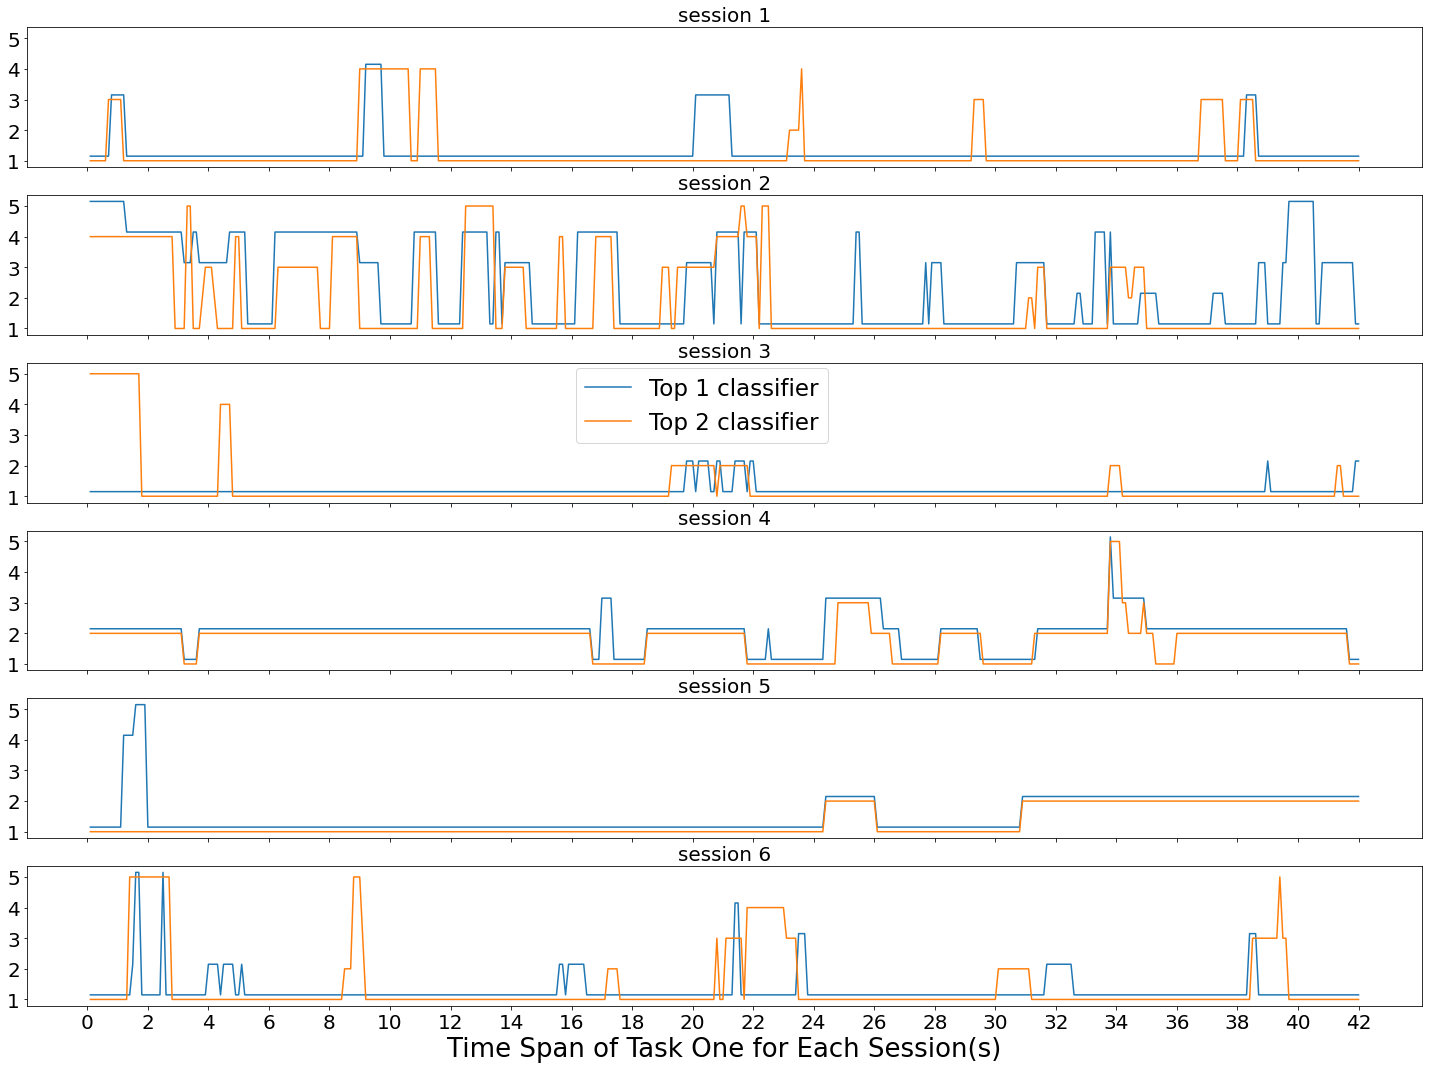

In [5]:
#task 1 Best and the second best
#task 1
interval_lst = [(0, 419), (420, 839), (840, 1259), (1260, 1679), (1680, 2099), (2100, 2549)]
should_be_ignored = []
task_one = [1,2,1,1,2,1]
task_one_idx = []
for i in range(len(task_one)):
    starting = 2100 * i
    pos = task_one[i]
    interval = interval_lst[pos - 1]
    idx_first = starting + interval[0]
    idx_second = starting + interval[1]
    task_one_idx.append((idx_first, idx_second))

x_axis = [i + 1 for i in range(420)]
x_axis = [i/10 for i in x_axis]
y_axis = [i for i in range(6)]
fig, axs = plt.subplots(6, sharex=True, sharey=True, figsize=(25, 18))

best_predicted_y = [ele+0.15 for ele in best_predicted_y]

y_temp_top_1 = best_predicted_y[task_one_idx[0][0] : task_one_idx[0][1] + 1]
y_temp_top_2 = second_best_predicted_y[task_one_idx[0][0] : task_one_idx[0][1] + 1]
l1, = axs[0].plot(x_axis, y_temp_top_1, label = 'Top 1 classifier')
l2, = axs[0].plot(x_axis, y_temp_top_2, label = 'Top 2 classifier')
axs[0].set_yticklabels(labels=y_axis, fontsize=20)
axs[0].set_title("session 1", fontsize=20)

y_temp_top_1 = best_predicted_y[task_one_idx[1][0] : task_one_idx[1][1] + 1]
y_temp_top_2 = second_best_predicted_y[task_one_idx[1][0] : task_one_idx[1][1] + 1]
axs[1].plot(x_axis, y_temp_top_1, label = 'Top 1 classifier')
axs[1].plot(x_axis, y_temp_top_2, label = 'Top 2 classifier')
axs[1].set_yticklabels(labels=y_axis, fontsize=20)
axs[1].set_title("session 2", fontsize=20)

y_temp_top_1 = best_predicted_y[task_one_idx[2][0] : task_one_idx[2][1] + 1]
y_temp_top_2 = second_best_predicted_y[task_one_idx[2][0] : task_one_idx[2][1] + 1]
axs[2].plot(x_axis, y_temp_top_1, label = 'Top 1 classifier')
axs[2].plot(x_axis, y_temp_top_2, label = 'Top 2 classifier')
axs[2].set_yticklabels(labels=y_axis, fontsize=20)
axs[2].set_title("session 3", fontsize=20)

y_temp_top_1 = best_predicted_y[task_one_idx[3][0] : task_one_idx[3][1] + 1]
y_temp_top_2 = second_best_predicted_y[task_one_idx[3][0] : task_one_idx[3][1] + 1]
axs[3].plot(x_axis, y_temp_top_1, label = 'Top 1 classifier')
axs[3].plot(x_axis, y_temp_top_2, label = 'Top 2 classifier')
axs[3].set_yticklabels(labels=y_axis, fontsize=20)
axs[3].set_title("session 4", fontsize=20)

y_temp_top_1 = best_predicted_y[task_one_idx[4][0] : task_one_idx[4][1] + 1]
y_temp_top_2 = second_best_predicted_y[task_one_idx[4][0] : task_one_idx[4][1] + 1]
axs[4].plot(x_axis, y_temp_top_1, label = 'Top 1 classifier')
axs[4].plot(x_axis, y_temp_top_2, label = 'Top 2 classifier')
axs[4].set_yticklabels(labels=y_axis, fontsize=20)
axs[4].set_title("session 5", fontsize=20)


y_temp_top_1 = best_predicted_y[task_one_idx[5][0] : task_one_idx[5][1] + 1]
y_temp_top_2 = second_best_predicted_y[task_one_idx[5][0] : task_one_idx[5][1] + 1]
axs[5].plot(x_axis, y_temp_top_1, label = 'Top 1 classifier')
axs[5].plot(x_axis, y_temp_top_2, label = 'Top 2 classifier')
axs[5].set_yticklabels(labels=y_axis, fontsize=20)
axs[5].set_title("session 6", fontsize=20)

plt.xticks(np.arange(0, 43, 2),fontsize=20)
plt.xlabel('Time Span of Task One for Each Session(s)', fontsize=26)
fig.legend((l1, l2), ('Top 1 classifier', 'Top 2 classifier'), fontsize=23, bbox_to_anchor=(0.5, 0.55), loc=8)
plt.savefig("Time_Majority_results/"+data_source+"/TMV/subejct_"+str(subject_id_search)+"_best_second_task_1.jpg", dpi = 1000)

plt.show()

In [6]:
print("subject_best_classifier_name is", subject_best_classifier_name)
print("="*20)
print("Time continuity subject dictionary is", time_continuity_subject)
print()
print("subject accuracy_Best_classifier", subject_accuracy_best_classifier_dict)
print()
print("subject accuracy_TMV", subject_accuracy_tmv_dict)

subject_best_classifier_name is {'1': 'RandomForest', '2': 'RandomForest', '3': 'RandomForest', '5': 'RBF SVM', '8': 'RandomForest', '9': 'RandomForest', '10': 'RandomForest', '12': 'RandomForest', '13': 'RandomForest', '14': 'RandomForest', '15': 'RandomForest', '17': 'RandomForest'}
{1: ['RandomForest', 'RBF SVM'], 2: ['RandomForest', 'RBF SVM'], 3: ['RandomForest', 'RBF SVM'], 4: [], 5: ['RBF SVM', 'RandomForest'], 6: [], 7: [], 8: ['RandomForest', 'RBF SVM'], 9: ['RandomForest', 'RBF SVM'], 10: ['RandomForest', 'RBF SVM'], 11: [], 12: ['RandomForest', 'RBF SVM'], 13: ['RandomForest', 'RBF SVM'], 14: ['RandomForest', 'RBF SVM'], 15: ['RandomForest', 'RBF SVM'], 16: [], 17: ['RandomForest', 'RBF SVM']}

Time continuity subject dictionary is {1: 137.1001992225647, 2: 132.61976385116577, 3: 131.64233803749084, 5: 94.92742896080017, 8: 110.28221702575684, 9: 17.577597856521606, 10: 114.9063549041748, 12: 112.2978413105011, 13: 71.5099151134491, 14: 74.1857898235321, 15: 75.876718044281,

In [7]:
print("data percentage left for all subjects", data_left_for_subjects)

data percentage left for all subjects {1: 0.63, 2: 0.37333333333333335, 3: 0.4666666666666667, 5: 0.28, 8: 0.44333333333333336, 9: 0.2, 10: 0.25666666666666665, 12: 0.28, 13: 0.25666666666666665, 14: 0.32666666666666666, 15: 0.37333333333333335, 17: 0.18666666666666668}


In [8]:
print("Dicts_order is:")
names.append("subject's top_2 classifier")
dicts_records.append(subject_accuracy_top_2_classifier_dict)
names.append("subject's best classifier")
dicts_records.append(subject_accuracy_best_classifier_dict)
names.append("TMV")
dicts_records.append(subject_accuracy_tmv_dict)
for name, dicts_record in zip(names, dicts_records):
    print(name)
    print(dicts_record)
    print()
print("="*20)

Dicts_order is:
LDA
{'1': 0.4696825396825397, '2': 0.43825396825396823, '3': 0.3367460317460317, '5': 0.48726190476190473, '8': 0.35277777777777775, '9': 0.6353703703703704, '10': 0.34825396825396826, '12': 0.2815873015873016, '13': 0.40228571428571425, '14': 0.435, '15': 0.39420634920634917, '17': 0.4023809523809524}

Nearest Neighbors
{'1': 0.6292857142857143, '2': 0.4714285714285715, '3': 0.5312698412698413, '5': 0.5176190476190476, '8': 0.46452380952380956, '9': 0.5738888888888889, '10': 0.3892063492063493, '12': 0.38611111111111107, '13': 0.4261904761904762, '14': 0.4621428571428572, '15': 0.3911904761904762, '17': 0.4707936507936509}

RandomForest
{'1': 0.7096825396825397, '2': 0.5649206349206349, '3': 0.566031746031746, '5': 0.5646428571428571, '8': 0.5203968253968254, '9': 0.6924074074074075, '10': 0.45976190476190476, '12': 0.4742063492063492, '13': 0.4801904761904762, '14': 0.5369047619047619, '15': 0.4943650793650793, '17': 0.5193650793650794}

RBF SVM
{'1': 0.67968253968253

In [9]:
# This block rearranges the result of different classfiers based on the accuracy, and sort subject id's based on the 
# classifier that performed the best
dict_sum_recorder = {}
for name, dicts_record in zip(names, dicts_records):
    cur = sum(dicts_record.values())
    dict_sum_recorder[name] = cur
dict_sum_recorder = dict(sorted(dict_sum_recorder.items(), key=lambda item: -item[1]))
classifier_order = list(dict_sum_recorder.keys())
print("the order of the classifier is: ")
print(classifier_order)
print()
best_classifier_name = classifier_order[0]
print("The best classifier is: " + best_classifier_name)
best_classifier_dict = dicts_records[names.index(best_classifier_name)]
print("the dictionary for the best classifier is: ")
print(best_classifier_dict)
print()

best_classifier_dict_sorted = dict(sorted(best_classifier_dict.items(), key=lambda item: -item[1]))
subject_id_order = list(best_classifier_dict_sorted.keys()) # The x axis of the plot
print("best_classifier_dict_sorted is: ")
print(best_classifier_dict_sorted)
print()
print("The order of the subject id is")
print(subject_id_order)
print()

result_y_res = [] # each element follows the order of the classifier_order
for i in range(len(classifier_order)):
    temp_lst = []
    classifier = classifier_order[i]
    for subject in subject_id_order:
        idx = names.index(classifier)
        temp_lst.append(dicts_records[idx][subject])
    result_y_res.append(temp_lst)

[{'1': 0.4696825396825397, '2': 0.43825396825396823, '3': 0.3367460317460317, '5': 0.48726190476190473, '8': 0.35277777777777775, '9': 0.6353703703703704, '10': 0.34825396825396826, '12': 0.2815873015873016, '13': 0.40228571428571425, '14': 0.435, '15': 0.39420634920634917, '17': 0.4023809523809524}, {'1': 0.6292857142857143, '2': 0.4714285714285715, '3': 0.5312698412698413, '5': 0.5176190476190476, '8': 0.46452380952380956, '9': 0.5738888888888889, '10': 0.3892063492063493, '12': 0.38611111111111107, '13': 0.4261904761904762, '14': 0.4621428571428572, '15': 0.3911904761904762, '17': 0.4707936507936509}, {'1': 0.7096825396825397, '2': 0.5649206349206349, '3': 0.566031746031746, '5': 0.5646428571428571, '8': 0.5203968253968254, '9': 0.6924074074074075, '10': 0.45976190476190476, '12': 0.4742063492063492, '13': 0.4801904761904762, '14': 0.5369047619047619, '15': 0.4943650793650793, '17': 0.5193650793650794}, {'1': 0.6796825396825396, '2': 0.5418253968253969, '3': 0.5619047619047619, '5':

In [11]:
subject_id_order.reverse()
print(subject_id_order)

['8', '13', '12', '10', '17', '3', '15', '14', '5', '2', '1', '9']



Time continuity subject dictionary is {1: 137.1001992225647, 2: 132.61976385116577, 3: 131.64233803749084, 5: 94.92742896080017, 8: 110.28221702575684, 9: 17.577597856521606, 10: 114.9063549041748, 12: 112.2978413105011, 13: 71.5099151134491, 14: 74.1857898235321, 15: 75.876718044281, 17: 33.91297101974487}

subject accuracy for their best classifier {'1': 0.7491181657848325, '2': 0.734077380952381, '3': 0.6729761904761905, '5': 0.6938492063492063, '8': 0.6159147869674185, '9': 0.8541666666666666, '10': 0.6458874458874458, '12': 0.6595238095238095, '13': 0.6424242424242425, '14': 0.7700680272108843, '15': 0.7293154761904762, '17': 0.6860119047619048}

subject accuracy_TMV {'1': 0.8350088183421517, '2': 0.8296130952380952, '3': 0.7903571428571429, '5': 0.8293650793650794, '8': 0.7304511278195489, '9': 0.8761111111111111, '10': 0.7813852813852814, '12': 0.7503968253968254, '13': 0.7435064935064936, '14': 0.819047619047619, '15': 0.819047619047619, '17': 0.7842261904761905}
best_classifi

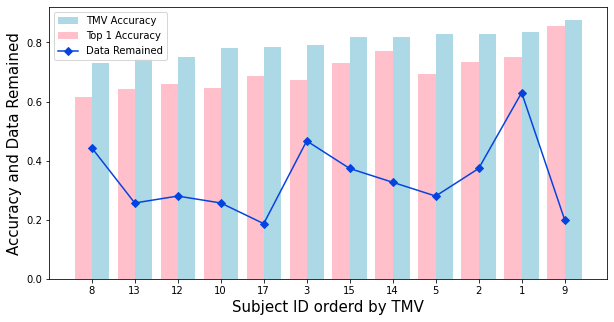

In [12]:
print()
print("Time continuity subject dictionary is", time_continuity_subject)
print()
print("subject accuracy for their best classifier", subject_accuracy_best_classifier_dict)
print()
print("subject accuracy_TMV", subject_accuracy_tmv_dict)

plt.figure(figsize=(10, 5))
best_classifier_predict = []
New_predict = []
percentage_left_subjects = []
time_data = []
for num in subject_id_order:
    best_classifier_predict.append(subject_accuracy_best_classifier_dict[num])
    New_predict.append(subject_accuracy_tmv_dict[num])
    percentage_left_subjects.append(data_left_for_subjects[int(num)])
    time_data.append(time_continuity_subject[int(num)])
    
RF_Phase2_accuracy = sum(best_classifier_predict) / len(best_classifier_predict)
TMV_accuracy = sum(New_predict) / len(New_predict)
print("="*20)
print("best_classifier_accuracy", RF_Phase2_accuracy)
print("TMV_accuracy", TMV_accuracy)
print("="*20)
print()
print("len of the time data", len(time_data))
X_axis = np.arange(len(subject_id_order))
plt.bar(X_axis - 0.2, best_classifier_predict, 0.4, label = 'Top 1 Accuracy', color = '#FFC0CB')
plt.bar(X_axis + 0.2, New_predict, 0.4, label = 'TMV Accuracy', color = '#ADD8E6')
plt.plot(X_axis, percentage_left_subjects, marker='D', label = 'Data Remained', color = "#0343DF")

handles, labels = plt.gca().get_legend_handles_labels()
print(labels)
order=[2,1,0]
plt.xticks(X_axis, subject_id_order)
plt.xlabel('Subject ID orderd by TMV', fontsize=15)
plt.ylabel('Accuracy and Data Remained', fontsize=15)
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=10, loc=0) 
plt.savefig("Time_Majority_results/"+data_source+"/Accuracy_all_subjects.jpg", bbox_inches='tight', dpi = 1500)
plt.show()

['8', '13', '12', '10', '17', '3', '15', '14', '5', '2', '1', '9']


<Figure size 720x360 with 0 Axes>

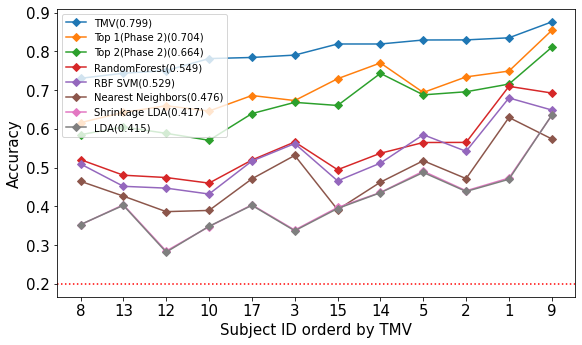

In [13]:
x_axis = subject_id_order
print(x_axis)

plt.figure(figsize=(10, 5))
fig, ax = plt.subplots()
for i in range(len(result_y_res)):
    result_y_res[i].reverse()
    y = result_y_res[i]
    label_name = classifier_order[i]
    temp_avg = dict_sum_recorder[label_name] / float(len(subject_id_order))
    temp_avg = round(temp_avg, 2)
    if label_name == "subject's top_2 classifier":
        label_name = "Top 2(Phase 2)"
    if label_name == "subject's best classifier":
        label_name = "Top 1(Phase 2)"
    if label_name == 'GradientBoosting':
        label_name = 'GradientBoost'
    if label_name == 'SLDA':
        label_name = 'sLDA'
    ax.plot(x_axis, y, marker='D', label = label_name + "(" + str(temp_avg)+")")

ax.set_position([0.1,0.5, 1.2, 1.0])
ax.legend(loc='upper left')
plt.axhline(y=0.2, color='r', linestyle=':')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Subject ID orderd by ' + best_classifier_name, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.savefig("Time_Majority_results/"+data_source+"/algorithm_comparison_each_subject.jpg", bbox_inches='tight', dpi = 1500)
plt.show()

TMV_avg_runtime 92.23659459749858

known percentage [0.5682222222222222, 0.44783333333333336, 0.454, 0.6303888888888889, 0.358, 0.5528333333333333, 0.43083333333333335, 0.43644444444444447, 0.5272222222222223, 0.5235555555555556, 0.6115, 0.3632222222222222]


<Figure size 720x360 with 0 Axes>

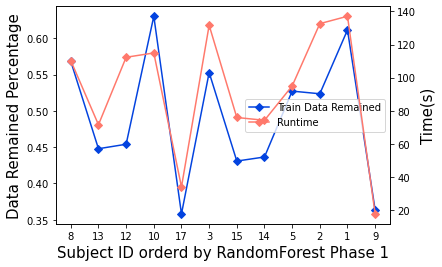

In [14]:
TMV_avg_runtime = sum(time_data)/len(time_data)
print("TMV_avg_runtime",TMV_avg_runtime)
print()
plt.figure(figsize=(10, 5))
fig, ax1 = plt.subplots()
known = []
for i in subject_id_order:
    known.append(subject_unknown_percentage[str(i)]["known"])
print("known percentage", known)
ax2 = ax1.twinx()
lns1 = ax1.plot(X_axis, known, marker='D', label = 'Train Data Remained', color = "#0343DF")
lns2 = ax2.plot(X_axis, time_data, marker='D', label = 'Runtime', color='#FF796C')
ax1.set_ylabel('Data Remained Percentage', fontsize=15)
ax2.set_ylabel('Time(s)', fontsize=15)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
ax1.set_xlabel('Subject ID orderd by RandomForest Phase 1', fontsize=15)
plt.xticks(X_axis, subject_id_order)
plt.savefig("Time_Majority_results/"+data_source+"/Data_Time.jpg", bbox_inches='tight', dpi = 1500)
plt.show()

In [15]:
time_spent_all_subjects = []
id_order_temp = subject_id_order[::-1]
for num in id_order_temp:
    time_spent_all_subjects.append(time_continuity_subject[int(num)])
time_spent_all_subjects = [round(i,3) for i in time_spent_all_subjects]

percentage_left_subjects = [round(j,3) for j in percentage_left_subjects]

data_time_elapsed = {"Code Runtime (s)": time_spent_all_subjects, "Percent of data left %": percentage_left_subjects}

df = pd.DataFrame(data_time_elapsed, index = id_order_temp)
df.to_csv("Time_Majority_results/"+data_source+"/Runtime_all_subjects.csv")
df

,Code Runtime (s),Percent of data left %
9,17.578,0.443
1,137.100,0.257
2,132.620,0.280
5,94.927,0.257
14,74.186,0.187
15,75.877,0.467
3,131.642,0.373
17,33.913,0.327
10,114.906,0.280
12,112.298,0.373


In [16]:
# record algorithm running time (new graph 3 rows: first row: mean accuracy)
#     accuracy code_runtime(s) (sorted based on accuracy)
# rf 0.56     15
 
# lda 0.4     xx

# adaboost 0.3 xx
tmv_average_time = sum(time_continuity_subject.values()) / float(len(subject_id_order))

time_classifier["TMV"] = tmv_average_time
avg_accuracy = []
time = []
name_list = []
counter = 0
second_best_classifier = list(dict_sum_recorder.items())[3][0]
third_best_classifier = list(dict_sum_recorder.items())[4][0]

second_best_classifier_time = 0
third_best_classifier_time = 0

top_1_2_algorithms_pair = []
for key in tmv_classifier_record:
    if len(tmv_classifier_record[key]) != 0:
        top_1_2_algorithms_pair.append(tmv_classifier_record[key])
        
print(top_1_2_algorithms_pair)
for pair in top_1_2_algorithms_pair:
    first_algo = pair[0]
    second_algo = pair[1]
    second_best_classifier_time += time_classifier[first_algo] / float(len(subject_id_order))
    third_best_classifier_time += time_classifier[second_algo] / float(len(subject_id_order))

print("Number of subjects is", len(subject_id_order))
for ele in dict_sum_recorder:
    name_list.append(ele)
    if ele == "subject's top_2 classifier":
        name_list.pop()
        name_temp = "Top 2 classifier (phase 2)"
        name_list.append(name_temp)
    if ele == "subject's best classifier":
        name_list.pop()
        name_temp = "Top 1 classifier (phase 2)"
        name_list.append(name_temp)
    temp_avg = dict_sum_recorder[ele] / float(len(subject_id_order))
    avg_accuracy.append(round(temp_avg, 2))
    temp_time = 0
    if ele == "subject's best classifier":
#         temp_time = time_classifier[second_best_classifier] / float(len(subject_id_order))
        temp_time = second_best_classifier_time / float(len(subject_id_order))
    elif ele == "subject's top_2 classifier":
#         temp_time = time_classifier[third_best_classifier] / float(len(subject_id_order))
        temp_time = third_best_classifier_time / float(len(subject_id_order))
    else:
        temp_time = time_classifier[ele] / float(len(subject_id_order))
    time.append(round(temp_time, 1))

print()
print("avg accuracy", avg_accuracy)
print("time", time)
print("name order", name_list)

data = {'Average Accuracy':avg_accuracy, 'Avg code runtime(s)':time}
# Creates pandas DataFrame.  
df = pd.DataFrame(data, index = name_list)
df.to_csv("Time_Majority_results/"+data_source+"/accuracy_runtime_classifier.csv")
df

The time_classifier is {'LDA': 2.6899185180664062, 'Nearest Neighbors': 25.80215358734131, 'RandomForest': 604.7222361564636, 'RBF SVM': 469.75491976737976, 'Shrinkage LDA': 2.8493716716766357, 'TMV': 92.23659459749858}
The dict_sum_recorder is {'TMV': 9.588516403593157, "subject's best classifier": 8.453333303195459, "subject's top_2 classifier": 7.968781926557615, 'RandomForest': 6.5828756613756605, 'RBF SVM': 6.349645502645503, 'Nearest Neighbors': 5.713650793650793, 'Shrinkage LDA': 5.000105820105821, 'LDA': 4.983806878306877}
[['RandomForest', 'RBF SVM'], ['RandomForest', 'RBF SVM'], ['RandomForest', 'RBF SVM'], ['RBF SVM', 'RandomForest'], ['RandomForest', 'RBF SVM'], ['RandomForest', 'RBF SVM'], ['RandomForest', 'RBF SVM'], ['RandomForest', 'RBF SVM'], ['RandomForest', 'RBF SVM'], ['RandomForest', 'RBF SVM'], ['RandomForest', 'RBF SVM'], ['RandomForest', 'RBF SVM']]
Number of subjects is 12

avg accuracy [0.8, 0.7, 0.66, 0.55, 0.53, 0.48, 0.42, 0.42]
time [7.7, 49.5, 40.1, 50.4,

,Average Accuracy,Avg code runtime(s)
TMV,0.80,7.7
Top 1 classifier (phase 2),0.70,49.5
Top 2 classifier (phase 2),0.66,40.1
RandomForest,0.55,50.4
RBF SVM,0.53,39.1
Nearest Neighbors,0.48,2.2
Shrinkage LDA,0.42,0.2
LDA,0.42,0.2


In [17]:
tmv_result_dict = tmv_result_dict_all_subjects[subject_id_search]

<ipython-input-18-dd53c4e5484f>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(labels=np.arange(-1,6,1), fontsize=15)
<ipython-input-18-dd53c4e5484f>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(labels=np.arange(-1,6,1), fontsize=15)


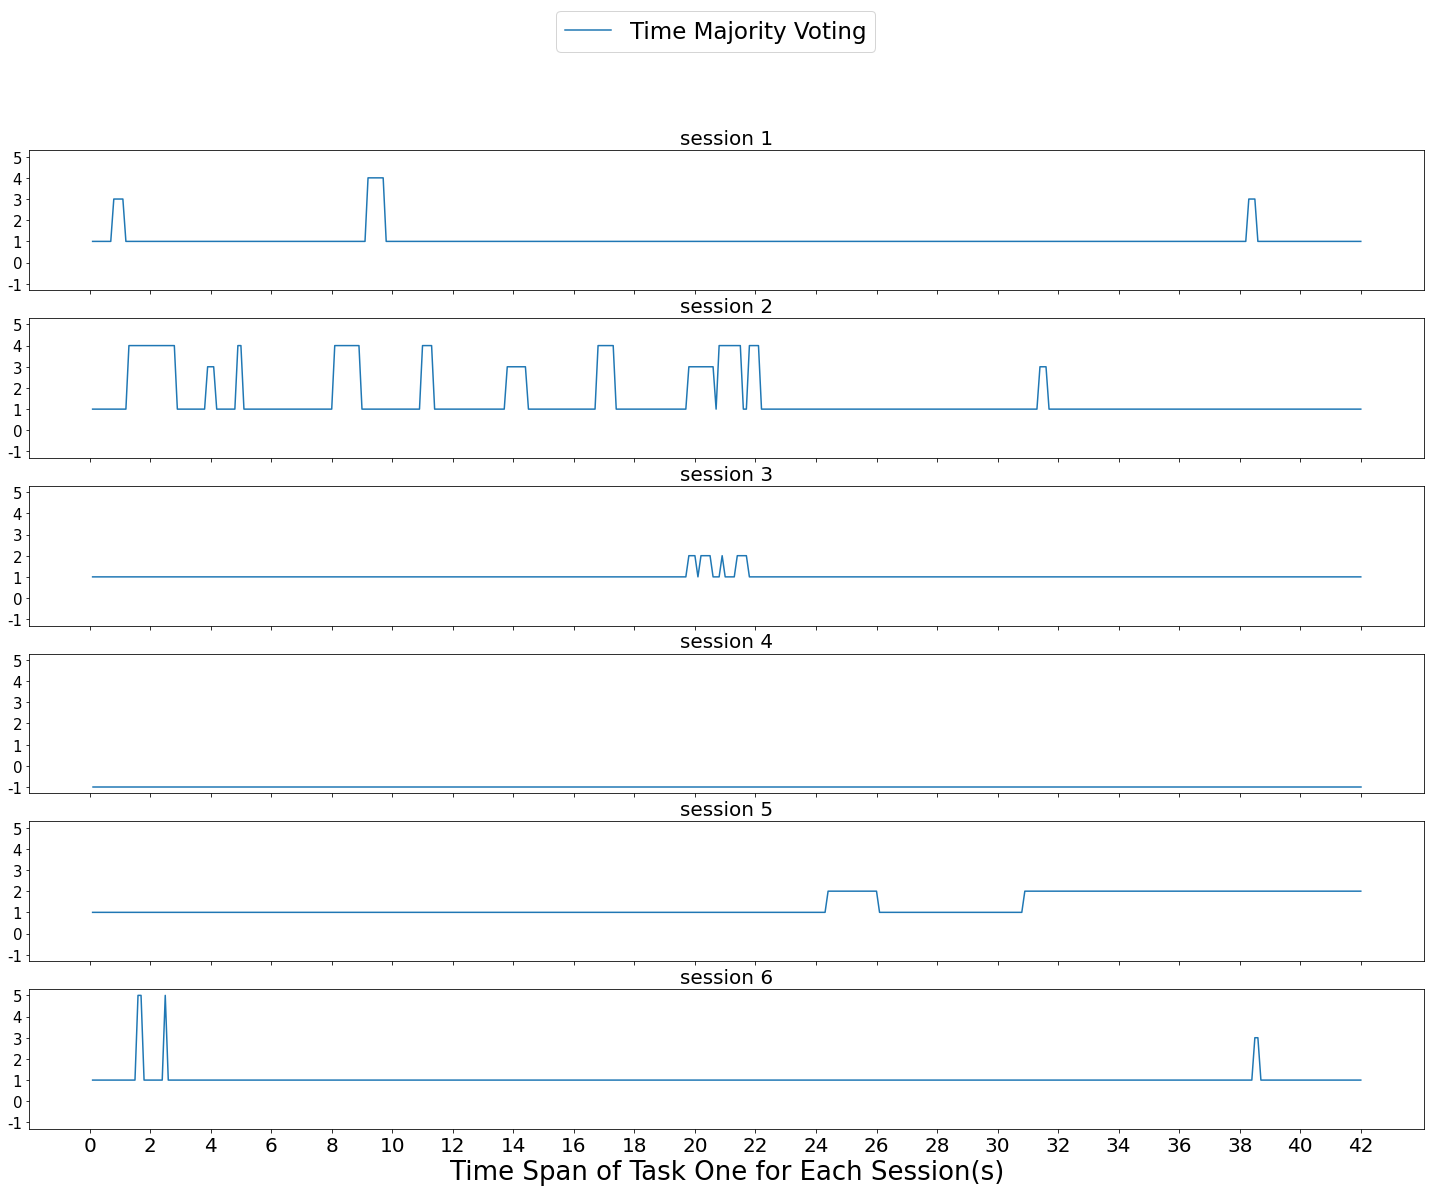

In [18]:
#subject_1_task_1 (or the subject_id_end)
subject_id_tmv = subject_id_search
interval_session_lst = [(0, 420), (420, 840), (840, 1260), (1260, 1680), (1680, 2100), (2100, 2520)]
task_num = 1


tmv_predicted = tmv_result_dict[str(task_num)]
all_ones = [i for i in tmv_predicted if i == -1]
x_axis = [i + 1 for i in range(420)]
x_axis = [i/10 for i in x_axis]

fig, axs = plt.subplots(6, sharex=True, sharey=True, figsize=(25, 18))


y_temp_tmv = tmv_predicted[0 : 420]
axs[0].plot(x_axis, y_temp_tmv, label = 'Time Majority Voting')
axs[0].set_yticklabels(labels=np.arange(-1,6,1), fontsize=15)
axs[0].set_title("session 1", fontsize=20)

for i in range(1, len(interval_session_lst)):

    interval_session = interval_session_lst[i]
    y_temp_tmv = tmv_predicted[interval_session[0] : interval_session[1]]
    axs[i].plot(x_axis, y_temp_tmv)
    axs[i].set_yticklabels(labels=np.arange(-1,6,1), fontsize=15)
    axs[i].set_title("session "+str(i + 1), fontsize=20)

plt.xticks(np.arange(0, 43, 2),fontsize=20)
plt.yticks(np.arange(-1,6,1), fontsize=15)
plt.xlabel('Time Span of Task One for Each Session(s)', fontsize=26)
fig.legend(fontsize=23, loc=9)
plt.savefig("Time_Majority_results/"+data_source+"/TMV/subject_"+str(subject_id_tmv)+"_task_1.jpg", dpi = 1000) ## Or it's subject_id_end

[[0.89047619 0.06714286 0.0147619  0.02619048 0.00142857]
 [0.04206349 0.85079365 0.04047619 0.03492063 0.03174603]
 [0.02896825 0.08809524 0.78968254 0.05873016 0.03452381]
 [0.03333333 0.04365079 0.08214286 0.81785714 0.02301587]
 [0.         0.1577381  0.00119048 0.00535714 0.83571429]]


Text(0.5, 1.0, 'subject_1 all six sessions TMV')

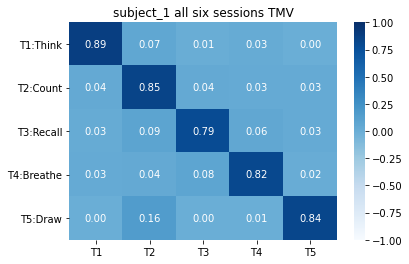

In [19]:
# Draw heatmap 
heatmap_data = np.zeros((5, 5))
for key in tmv_result_dict:
    res = []
    y = tmv_result_dict[key]
    y = [z for z in y if z != -1]
    for j in range(1,6):
        total_j = len([i for i in y if i == j])
        val = total_j / float(len(y))
        res.append(float(val))
    heatmap_data[int(key) - 1] = res
print(heatmap_data)
x_axis_labels = ["T1","T2","T3","T4","T5"]
y_axis_labels = ["T1:Think","T2:Count","T3:Recall","T4:Breathe","T5:Draw"]
ax = sns.heatmap(heatmap_data, cmap="Blues", vmin= -1, vmax=1, annot=True, fmt=".2f", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.savefig("Time_Majority_results/"+data_source+"/TMV/subejct_"+str(subject_id_tmv)+"_TMV_heatmap.jpg", dpi = 800)
plt.title("subject_" + str(subject_id_tmv) + " all six sessions TMV")

In [20]:
print(tmv_classifier_record)
print("="*20)

{1: ['RandomForest', 'RBF SVM'], 2: ['RandomForest', 'RBF SVM'], 3: ['RandomForest', 'RBF SVM'], 4: [], 5: ['RBF SVM', 'RandomForest'], 6: [], 7: [], 8: ['RandomForest', 'RBF SVM'], 9: ['RandomForest', 'RBF SVM'], 10: ['RandomForest', 'RBF SVM'], 11: [], 12: ['RandomForest', 'RBF SVM'], 13: ['RandomForest', 'RBF SVM'], 14: ['RandomForest', 'RBF SVM'], 15: ['RandomForest', 'RBF SVM'], 16: [], 17: ['RandomForest', 'RBF SVM']}


In [21]:
tmv_algorithm_first = []
tmv_algorithm_second = []
ids = []

for key in tmv_classifier_record:
    algorithms = tmv_classifier_record[key]
    if len(algorithms) == 0:
        continue
    ids.append(key)
    tmv_algorithm_first.append(algorithms[0])
    tmv_algorithm_second.append(algorithms[1])

data_algorithms = {"First Algorithm Used":tmv_algorithm_first, "Second Algorithm Used":tmv_algorithm_second}
df_2 = pd.DataFrame(data_algorithms, index = ids)
df_2.to_csv("Time_Majority_results/"+data_source+"/TMV/classifiers_used_TMV.csv")
print(df_2)

   First Algorithm Used Second Algorithm Used
1          RandomForest               RBF SVM
2          RandomForest               RBF SVM
3          RandomForest               RBF SVM
5               RBF SVM          RandomForest
8          RandomForest               RBF SVM
9          RandomForest               RBF SVM
10         RandomForest               RBF SVM
12         RandomForest               RBF SVM
13         RandomForest               RBF SVM
14         RandomForest               RBF SVM
15         RandomForest               RBF SVM
17         RandomForest               RBF SVM
